In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow
from src import models
import torch.nn.functional as F


mltrainer.__version__

'0.1.129'

In [20]:
confusion_matrixs = {}

In [2]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm):
    plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
    plot.set(xlabel="Predicted", ylabel="Target")
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [3]:
def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart2D",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )



            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_oversampled")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
                "shape": config["shape"]
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [4]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

if torch.backends.mps.is_available():
            device = torch.device('mps')
            print('MPS is available')
else:
            device = torch.device('cpu')

{'ptb': 'heart', 'arrhythmia': 'heart_big'}
MPS is available


In [5]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [38]:
#trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')


In [6]:
# 2D dataset with shape = (16, 12)
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#275000), Heartdataset2D (#21892))

In [7]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [27]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

2025-01-26 16:39:15.531 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-163915
2025-01-26 16:39:15.532 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2DResNetSE(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SEBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (

100%|██████████| 2264/2264 [00:55<00:00, 40.73it/s]
2025-01-26 16:40:12.760 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4273 test 0.2853 metric ['0.8971', '0.8971', '0.6821', '0.8971', '0.9009']
100%|██████████| 2264/2264 [00:55<00:00, 40.98it/s]
2025-01-26 16:41:09.665 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2473 test 0.2512 metric ['0.9000', '0.9000', '0.6846', '0.9000', '0.9089']
100%|██████████| 2264/2264 [00:56<00:00, 40.25it/s]
2025-01-26 16:42:07.545 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2005 test 0.2004 metric ['0.9269', '0.9269', '0.7339', '0.9269', '0.9292']
100%|██████████| 2264/2264 [00:55<00:00, 40.55it/s]
2025-01-26 16:43:05.046 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1699 test 0.1900 metric ['0.9299', '0.9299', '0.7476', '0.9299', '0.9288']
100%|██████████| 2264/2264 [00:55<00:00, 40.56it/s]
2025-01-26 16:44:02.552 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1446 test 0.2412 met

{'model': 'Transformer2DResNetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


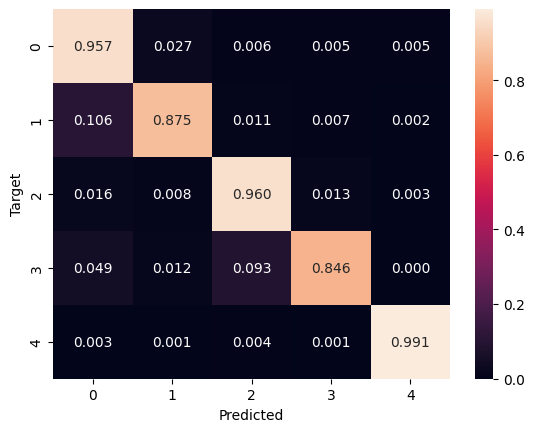

In [42]:

modelname= "Transformer2DResNetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNetSE(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
confusion_matrixs[modelname] = cfm

print(config)
plot_confusion_matrix(cfm)


2025-01-26 16:53:46.189 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-165346
2025-01-26 16:53:46.189 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNetWithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2DResNetWithAttention(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (se_block): SqueezeExciteBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (pos_encoder): PositionalEncoding(


100%|██████████| 2264/2264 [00:55<00:00, 41.08it/s]
2025-01-26 16:54:42.942 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4406 test 0.4087 metric ['0.8653', '0.8653', '0.6337', '0.8653', '0.8921']
100%|██████████| 2264/2264 [00:55<00:00, 40.81it/s]
2025-01-26 16:55:40.033 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2560 test 0.3123 metric ['0.8920', '0.8920', '0.6700', '0.8920', '0.9037']
100%|██████████| 2264/2264 [00:55<00:00, 40.69it/s]
2025-01-26 16:56:37.298 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2050 test 0.3265 metric ['0.8617', '0.8617', '0.6554', '0.8617', '0.9018']
2025-01-26 16:56:37.298 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.3123, current loss 0.3265.Counter 1/8.
100%|██████████| 2264/2264 [00:55<00:00, 40.55it/s]
2025-01-26 16:57:34.760 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1694 test 0.2754 metric ['0.9122', '0.9122', '0.7188', '0.9122', '0.9351']
100%|██████████| 2264/2264 [00:55<

{'model': 'Transformer2DResNetWithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


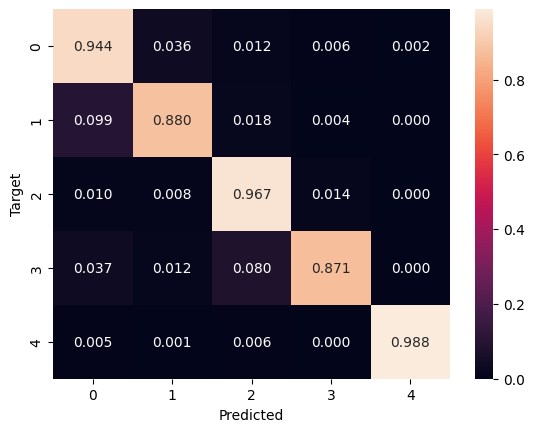

In [44]:

modelname= "Transformer2DResNetWithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNetWithAttention(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-26 17:08:10.825 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-170810
2025-01-26 17:08:10.825 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
resnet block
Transformer2DResNet(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128,

100%|██████████| 2264/2264 [00:53<00:00, 42.05it/s]
2025-01-26 17:09:06.299 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4263 test 0.3295 metric ['0.8849', '0.8849', '0.6577', '0.8849', '0.8855']
100%|██████████| 2264/2264 [00:53<00:00, 42.00it/s]
2025-01-26 17:10:01.832 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2492 test 0.2825 metric ['0.8847', '0.8847', '0.6707', '0.8847', '0.9020']
100%|██████████| 2264/2264 [00:53<00:00, 42.01it/s]
2025-01-26 17:10:57.345 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1991 test 0.1802 metric ['0.9331', '0.9331', '0.7664', '0.9331', '0.9302']
100%|██████████| 2264/2264 [00:54<00:00, 41.53it/s]
2025-01-26 17:11:53.468 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1681 test 0.2283 metric ['0.9044', '0.9044', '0.6953', '0.9044', '0.9258']
2025-01-26 17:11:53.468 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.1802, current loss 0.2283.Counter 1/8.
100%|██████████| 2264/2264 [00:54<

{'model': 'Transformer2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


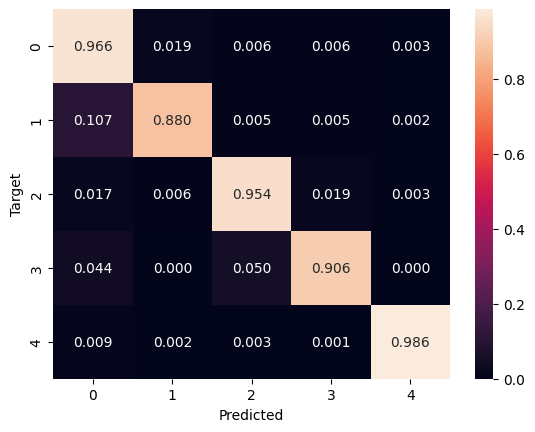

In [45]:

modelname= "Transformer2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}
print(config)
model = models.Transformer2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

In [18]:
from torchsummary import summary
modelname= "AttentionGRU"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_layers": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "input": 1,
    
   
}
print(config)
model = models.AttentionGRU(config)
print(model)
# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 16, 12)


# # Generate the visualization
# y = model(dummy_input)
# dot = make_dot(y, params=dict(model.named_parameters()))
# dot.format = 'png'
# dot.render("Transformer2DResNet")

summary(model, input_size=(192, 1))


{'model': 'AttentionGRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'hidden': 128, 'dropout': 0.2, 'num_layers': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5, 'input': 1}
AttentionGRU(
  (rnn): GRU(1, 128, num_layers=5, batch_first=True, dropout=0.2)
  (rnn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 192, 128], [-1, 2, 128]]               0
         LayerNorm-2             [-1, 192, 128]             256
MultiheadAttention-3  [[-1, 192, 128], [-1, 192, 192]]               0
         LayerNorm-4             [-1, 192, 

In [16]:
summary(model, input_size=(1, 16, 12))

ValueError: GRU: Expected input to be 2D or 3D, got 4D instead

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot



# Example configuration
config = {
    "hidden": 128,
    "shape": (16, 12),
    "num_classes": 5
}

# Instantiate the model
model = models.Transformer2DResNet(config)




In [57]:
modelname= "GRU"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input_size": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.GRUmodel(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-26 21:10:52.806 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250126-211052
2025-01-26 21:10:52.807 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'GRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input_size': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
{'model': 'GRU', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input_size': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
GRUmodel(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)


100%|██████████| 1718/1718 [02:10<00:00, 13.20it/s]
2025-01-26 21:13:06.816 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2788 test 1.3937 metric ['0.3261', '0.3261', '0.2235', '0.3261', '0.4973']
100%|██████████| 1718/1718 [02:09<00:00, 13.28it/s]
2025-01-26 21:15:19.972 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5661 test 0.6539 metric ['0.7567', '0.7567', '0.5570', '0.7567', '0.8038']
100%|██████████| 1718/1718 [02:08<00:00, 13.37it/s]
2025-01-26 21:17:32.270 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3529 test 0.3244 metric ['0.9081', '0.9081', '0.7073', '0.9081', '0.8956']
100%|██████████| 1718/1718 [02:06<00:00, 13.53it/s]
2025-01-26 21:19:43.072 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2621 test 0.3043 metric ['0.9037', '0.9037', '0.7038', '0.9037', '0.9143']
100%|██████████| 1718/1718 [02:07<00:00, 13.51it/s]
2025-01-26 21:21:54.091 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.2123 test 0.2816 met

2025-01-27 16:23:24.851 | INFO     | src.models:__init__:38 - Activation map size: 48
2025-01-27 16:23:24.851 | INFO     | src.models:__init__:39 - Input linear: 6144
2025-01-27 16:23:24.859 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250127-162324
2025-01-27 16:23:24.859 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 1718/1718 [03:36<00:00,  7.92it/s]
2025-01-27 16:27:08.791 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5103 test 0.3820 metric ['0.8672', '0.8672', '0.6185', '0.8672', '0.8827']
100%|██████████| 1718/1718 [04:04<00:00,  7.02it/s]
2025-01-27 16:31:20.439 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2021 test 0.3143 metric ['0.8890', '0.8890', '0.6912', '0.8890', '0.9244']
100%|██████████| 1718/1718 [03:37<00:00,  7.91it/s]
2025-01-27 16:35:04.468 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1324 test 0.2102 metric ['0.9308', '0.9308', '0.7562', '0.9308', '0.9317']
100%|██████████| 1718/1718 [03:37<00:00,  7.89it/s]
2025-01-27 16:38:49.221 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1000 test 0.1876 metric ['0.9409', '0.9409', '0.8041', '0.9409', '0.9323']
100%|██████████| 1718/1718 [03:37<00:00,  7.88it/s]
2025-01-27 16:42:34.227 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.0850 test 0.2268 met

{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


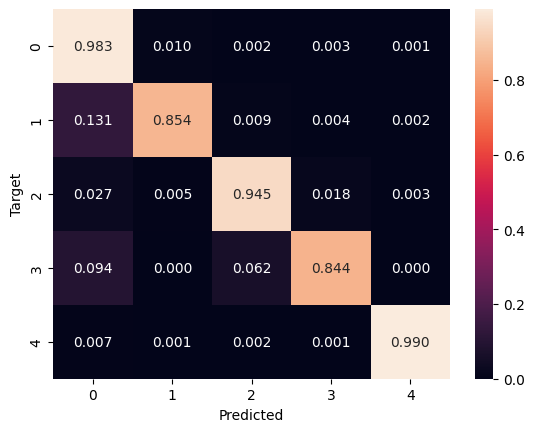

In [15]:
modelname= "CNN2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.CNN(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025/01/26 17:24:21 INFO mlflow.tracking.fluent: Experiment with name 'CNN2DResNet' does not exist. Creating a new experiment.
2025-01-26 17:24:21.932 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-172421
2025-01-26 17:24:21.932 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'CNN2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
CNN2DResNet(
  (convolutions): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ResNetBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequentia

100%|██████████| 1718/1718 [01:19<00:00, 21.58it/s]
2025-01-26 17:25:44.519 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2530 test 0.2162 metric ['0.9274', '0.9274', '0.7408', '0.9274', '0.9320']
100%|██████████| 1718/1718 [01:19<00:00, 21.56it/s]
2025-01-26 17:27:07.165 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1041 test 0.2881 metric ['0.8920', '0.8920', '0.7153', '0.8920', '0.9332']
2025-01-26 17:27:07.165 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2162, current loss 0.2881.Counter 1/8.
100%|██████████| 1718/1718 [01:19<00:00, 21.48it/s]
2025-01-26 17:28:30.132 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0755 test 0.1975 metric ['0.9368', '0.9368', '0.7887', '0.9368', '0.9268']
100%|██████████| 1718/1718 [01:19<00:00, 21.54it/s]
2025-01-26 17:29:52.940 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0615 test 0.1401 metric ['0.9563', '0.9563', '0.8291', '0.9563', '0.9473']
100%|██████████| 1718/1718 [01:20<

{'model': 'CNN2DResNet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


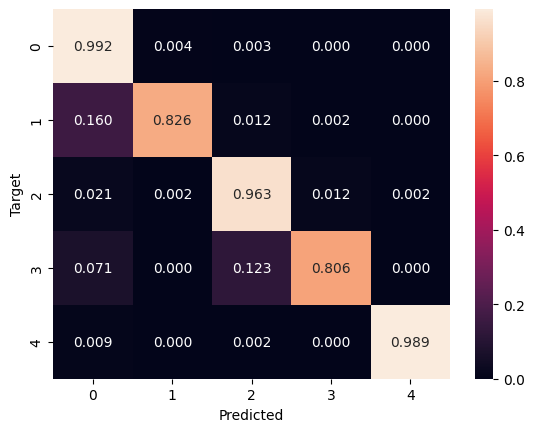

In [55]:
modelname= "CNN2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.CNN2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-26 18:24:06.045 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250126-182406
2025-01-26 18:24:06.045 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
Transformer2D(
  (convolutions): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_bloc

100%|██████████| 1718/1718 [02:08<00:00, 13.42it/s]
2025-01-26 18:26:18.669 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6974 test 0.4215 metric ['0.8681', '0.8681', '0.6504', '0.8681', '0.8558']
100%|██████████| 1718/1718 [02:06<00:00, 13.54it/s]
2025-01-26 18:28:30.117 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3492 test 0.4168 metric ['0.8477', '0.8477', '0.6106', '0.8477', '0.8736']
100%|██████████| 1718/1718 [02:06<00:00, 13.58it/s]
2025-01-26 18:30:41.132 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2630 test 0.1660 metric ['0.9432', '0.9432', '0.7669', '0.9432', '0.9188']
100%|██████████| 1718/1718 [02:05<00:00, 13.68it/s]
2025-01-26 18:32:51.251 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2149 test 0.2145 metric ['0.9308', '0.9308', '0.7471', '0.9308', '0.9180']
2025-01-26 18:32:51.252 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.1660, current loss 0.2145.Counter 1/8.
100%|██████████| 1718/1718 [02:06<

{'model': 'Transformer2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


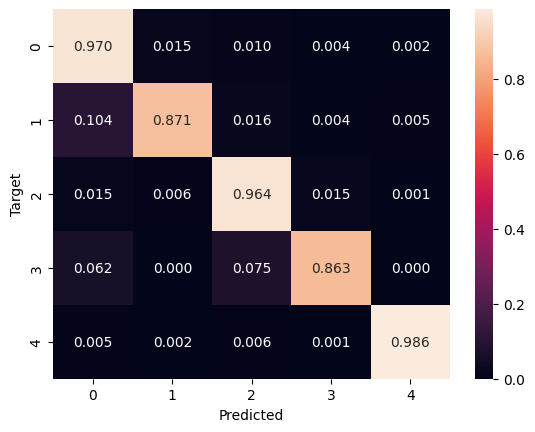

In [56]:
modelname= "Transformer2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer2D(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

# 1D MODELS

In [7]:
# 1D dataset
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")

In [8]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [9]:
x, y = traindataset[0]
x.shape

torch.Size([192, 1])

In [10]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

2025/01/26 20:42:51 INFO mlflow.tracking.fluent: Experiment with name 'Transformer1DResnet' does not exist. Creating a new experiment.
2025-01-26 20:42:51.861 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250126-204251
2025-01-26 20:42:51.861 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 1718/1718 [01:10<00:00, 24.42it/s]
2025-01-26 20:44:03.903 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5284 test 0.6547 metric ['0.7716', '0.7716', '0.5431', '0.7716', '0.8626']
100%|██████████| 1718/1718 [01:12<00:00, 23.77it/s]
2025-01-26 20:45:17.885 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3307 test 0.5459 metric ['0.8074', '0.8074', '0.5838', '0.8074', '0.8739']
100%|██████████| 1718/1718 [01:11<00:00, 24.10it/s]
2025-01-26 20:46:30.913 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2720 test 0.4035 metric ['0.8697', '0.8697', '0.6409', '0.8697', '0.8923']
100%|██████████| 1718/1718 [01:11<00:00, 24.05it/s]
2025-01-26 20:47:44.110 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2383 test 0.2882 metric ['0.9019', '0.9019', '0.6904', '0.9019', '0.9198']
100%|██████████| 1718/1718 [01:11<00:00, 23.96it/s]
2025-01-26 20:48:57.556 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.2156 test 0.3175 met

{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


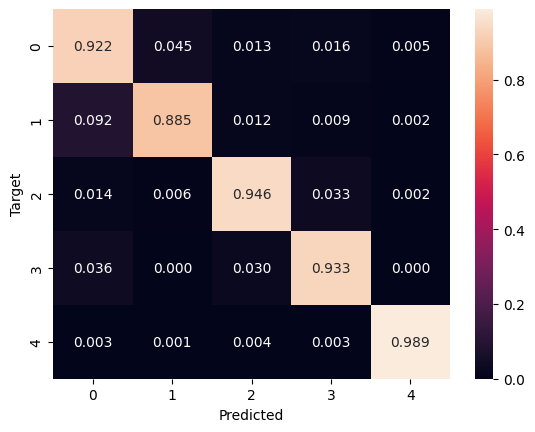

In [75]:

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025-01-27 09:54:01.701 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250127-095401
2025-01-27 09:54:01.702 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


100%|██████████| 1718/1718 [03:04<00:00,  9.32it/s]
2025-01-27 09:57:15.516 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4438 test 0.3626 metric ['0.8761', '0.8761', '0.6529', '0.8761', '0.8923']
100%|██████████| 1718/1718 [03:03<00:00,  9.36it/s]
2025-01-27 10:00:28.515 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2776 test 0.4471 metric ['0.8201', '0.8201', '0.6061', '0.8201', '0.8957']
2025-01-27 10:00:28.515 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.3626, current loss 0.4471.Counter 1/8.
100%|██████████| 1718/1718 [03:02<00:00,  9.39it/s]
2025-01-27 10:03:40.964 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2419 test 0.4170 metric ['0.8380', '0.8380', '0.6187', '0.8380', '0.9016']
2025-01-27 10:03:40.964 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.3626, current loss 0.4170.Counter 2/8.
100%|██████████| 1718/1718 [03:04<00:00,  9.33it/s]
2025-01-27 10:06:54.588 | INFO     | mltrainer.trainer:report:191 - Epo

{'model': 'Transformer1DResnet', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


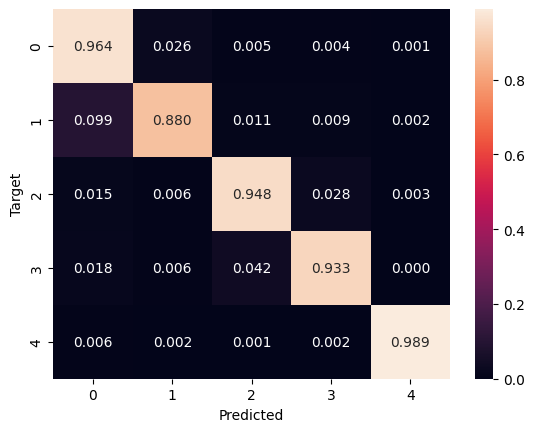

In [13]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1DResnet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer1DResnet(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

{'model': 'Transformer1DResnetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


2025-01-26 23:22:42.818 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250126-232242
2025-01-26 23:22:43.097 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [03:02<00:00,  9.39it/s]
2025-01-26 23:25:55.609 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4575 test 0.5718 metric ['0.7771', '0.7771', '0.5810', '0.7771', '0.8580']
100%|██████████| 1718/1718 [03:35<00:00,  7.96it/s]
2025-01-26 23:29:41.680 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2685 test 0.2363 metric ['0.9207', '0.9207', '0.7126', '0.9207', '0.8931']
100%|██████████| 1718/1718 [03:38<00:00,  7.85it/s]
2025-01-26 23:33:30.922 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2256 test 0.4060 metric ['0.8543', '0.8543', '0.6477', '0.8543', '0.9032']
2025-01-26 23:33:30.922 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.2363, current loss

{'model': 'Transformer1DResnetSE', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


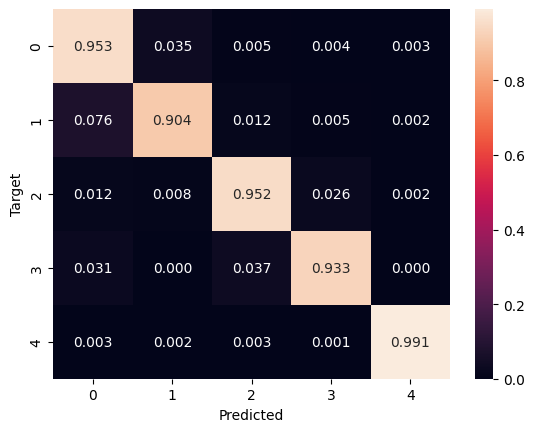

In [11]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1DResnetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer1DResnetSE(config)
yhat = model(x)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

In [ ]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

In [12]:

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs= {"patience": 8},
        device= device
    )

modelname= "Transformer1DResnetSEwithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 2,
    "num_classes": 5,
    "shape": (16, 12),
   
}


print(config)
model = models.Transformer1DResnetSEwithAttention(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm)

2025/01/27 04:23:16 INFO mlflow.tracking.fluent: Experiment with name 'Transformer1DResnetSEwithAttention' does not exist. Creating a new experiment.
2025-01-27 04:23:16.982 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250127-042316
2025-01-27 04:23:16.983 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


{'model': 'Transformer1DResnetSEwithAttention', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'num_classes': 5, 'num_heads': 8, 'num_blocks': 2, 'shape': (16, 12)}


  0%|          | 0/15 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [128, 1, 3], expected input[32, 192, 1] to have 1 channels, but got 192 channels instead

In [22]:
from datetime import datetime

# Get current date and time in a specific format (e.g., '2025-01-28_15-30-45')
current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Hash the string to create a seed
random_seed = hash(current_time_str)
print(f"Random Seed from Date and Time (hashed): {random_seed}")
current_time_str

Random Seed from Date and Time (hashed): 1902171767351478533


'2025-01-30_11-57-17'

In [23]:
import time

# Use the current date and time to generate a more unique seed
current_time_str = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
random_seed = int(time.mktime(time.strptime(current_time_str, "%Y-%m-%d %H:%M:%S")))
print(f"Random Seed from Date and Time: {random_seed}")

Random Seed from Date and Time: 1738234650


In [24]:
import random

# Generate a random integer between 0 and 2^32 - 1
random_seed = random.randint(0, 2**32 - 1)
print(f"Random Seed: {random_seed}")

Random Seed: 2921403402
